<a href="https://colab.research.google.com/github/marcusnk237/Time-Series-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading libraries and frameworks
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

# Function which split a dataset 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
numpy.random.seed(7)

In [ ]:
# Loading data
dt = pd.read_csv('/content/sample_data/file.csv', sep=';',header=None,na_values='?')
print(dt.head())
# Get the purcentage of missing datas
for i in range(dt.shape[1]):
	# count number of rows with missing values
	n_miss = dt[[i]].isnull().sum()
	perc = n_miss / dt.shape[0] * 100
	print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
# Get values
data = pd.DataFrame(dt)

hours =[i for i in range(len(data)-1)]
measures = [data[1][i+1] for i in range(len(data)-1)]

# Create a dictionnary of values
dictionnary={'Times':hours,'Measures':measures}
# Créate a dataframe
df=pd.DataFrame(dictionnary)

                     0          1
0           date_heure  mesure.m.
1  1990-01-01 00:00:00       7.59
2  1990-01-01 01:00:00        7.6
3  1990-01-01 02:00:00        7.6
4  1990-01-01 03:00:00        7.4
> 0, Missing: 0 (0.0%)
> 1, Missing: 16493 (7.0%)


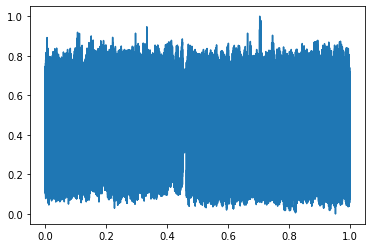

In [ ]:
#Data r econstruction with  KNN Imputer
imputer=KNNImputer(n_neighbors=1,weights='distance')
df=df.astype('float32')
scaler = MinMaxScaler(feature_range = (0, 1))
df= scaler.fit_transform(df)
dataframe = imputer.fit_transform(df)
# Print the result
plt.plot(dataframe[:,0],dataframe[:,1])
plt.show()

                 date_heure  mesurem
0       1990-01-01 00:00:00     7.59
1       1990-01-01 01:00:00     7.60
2       1990-01-01 02:00:00     7.60
3       1990-01-01 03:00:00     7.40
4       1990-01-01 04:00:00     6.53
...                     ...      ...
236684  2016-12-31 20:00:00     1.96
236685  2016-12-31 21:00:00     2.09
236686  2016-12-31 22:00:00     5.39
236687  2016-12-31 23:00:00     7.47
236688  2017-01-01 00:00:00     7.53

[236689 rows x 2 columns]


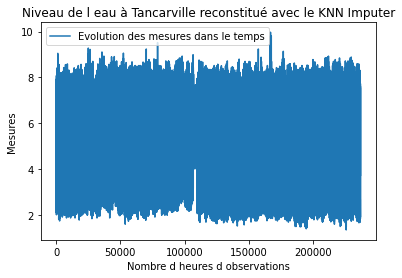

<Figure size 3600x3600 with 0 Axes>

In [ ]:
# undo the data normalization
J=mesure
J=numpy.array(J)
J = J.astype(numpy.float)
min_j=min(J)
max_j=max(J)
MIN=numpy.full((1, len(J)), min_j)
measure_kn=dataframe[:,1]*(max_j-min_j)+MIN
measure_knn=measure_kn[0]
for i in range(len(mesure_knn)):
  measure_knn[i]=float(int(measure_knn[i]*100))/100
date_knn=[]
for i in range(len(dt)-1):
	date_knn.append(dt[0][i+1])
 
# Create a dictionnary
dictio={'Times':date_knn,'Measures':mesure_knn}
# Création du DataFrame correspondant
dataf=pd.DataFrame(dictio)
print(dataf)
dataf.plot()
#plt.title('Titre')
plt.ylabel('Measures')
plt.xlabel('Time\'s observation')
plt.legend(['Evolution of  the measures accross the time'], loc='upper left')
plt.figure(figsize=(50,50))
plt.show()

In [ ]:
# Get the measures
dataset = dataf.iloc[:, 1:2].values
dataset = dataset.astype('float32')
# Data normalization
scaler = MinMaxScaler(feature_range = (0, 1))
dataset= scaler.fit_transform(dataset)
# Splitting the dataset into train set and test set
#a=len(dataset)
a=10000
train_size = int(a* 0.8)
test_size = a- train_size
train, test = dataset[0:train_size,:], dataset[train_size:a,:]
# Data resize
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Input resize
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Creation and training of the LSTM
model = Sequential()
model.add(LSTM(1000, input_shape=(1, look_back), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse', 'mae'])
history = model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1,shuffle=True,validation_split=0.2)
# PrEdictions
trainPredict = model.predict(trainX, batch_size=1)
model.reset_states()
testPredict = model.predict(testX, batch_size=1)
# Reconstruction
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# MSE computation
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Example
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:a-1, :] = testPredict


Epoch 1/100
100/100 [==============================] - 5s 49ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1752 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.1293
Epoch 2/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.1007 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0912
Epoch 3/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0891 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0913
Epoch 4/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0895 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0899
Epoch 5/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0889 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0909
Epoch 6/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0890 - val_loss: 0.0140 - val_mse: 0.0140 - val_mae: 0.0903
Epoc

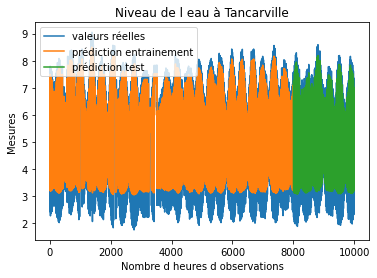

<Figure size 3600x3600 with 0 Axes>

In [ ]:
test = plt.figure()
plt.plot(scaler.inverse_transform(dataset[0:a]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
#plt.title('Niveau de l eau à Tancarville')
plt.ylabel('Measures')
plt.xlabel('Time\'s observation')
plt.legend(['real datas', 'training prediction','test prediction'], loc='upper left')
plt.figure(figsize=(50,50))
test.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


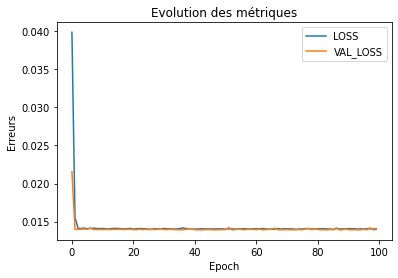

<Figure size 3600x3600 with 0 Axes>

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrics')
plt.ylabel('Errors')
plt.xlabel('Epoch')
plt.legend(['LOSS','VAL_LOSS'], loc='upper right')
plt.figure(figsize=(50,50))
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


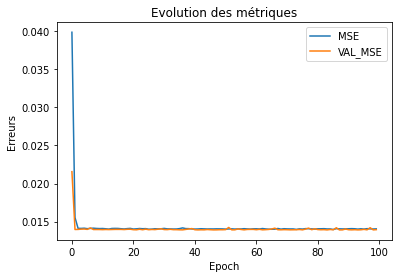

<Figure size 3600x3600 with 0 Axes>

In [ ]:
print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Metrics')
plt.ylabel('Errors')
plt.xlabel('Epoch')
plt.legend(['MSE','VAL_MSE'], loc='upper right')
plt.figure(figsize=(50,50))
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


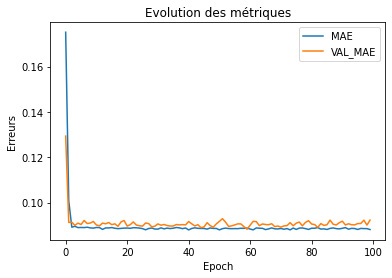

<Figure size 3600x3600 with 0 Axes>

In [ ]:
print(history.history.keys())
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Metrics')
plt.ylabel('Errors')
plt.xlabel('Epoch')
plt.legend(['MAE','VAL_MAE'], loc='upper right')
plt.figure(figsize=(50,50))
plt.show()